## Analytical Covariance 

We tried to calculate analytical covariance for NK and GK using TJPCov. \
In this example, we tried to calcualte covariance of NK and GK of the same bin. Specically, we did NK and GK for 0.8 < z < 1.0. The corresponding tracers are in test.sacc file. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import sacc
import sys
sys.path.insert(0, '/global/u1/z/zhzhuoqi/tjpcov/TJPCov')
sys.path.insert(0, '/global/u1/z/zhzhuoqi/firecrown/firecrown/')
sys.path.insert(0, '/global/homes/z/zhzhuoqi/.conda/envs/my-conda-env/lib/python3.8/site-packages/')
from tjpcov import wigner_transform, bin_cov, parse
d2r=np.pi/180

In [2]:
#this is the cosmology I use. 
cosmo = ccl.Cosmology(Omega_k=0.0, Omega_g=0.0, w0=-1.0, wa=0.0, T_CMB=2.7,
                      Neff=0, m_nu=0.0, transfer_function='bbks', mass_function='tinker',
                      Omega_b=0.045, Omega_c=0.21, h=0.71, sigma8=0.80, n_s=0.964)

In [3]:
twopoint_data = sacc.Sacc.load_fits('test.sacc')

#### Here we generate the CMB tracer noise. 

This is a smoothing function, used to smooth the truncated cmb noise.

In [4]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

Here we generate the cmb tracer noise. We only have up to l=3000 in the noise spectrum. So we set the noise for l>3000 as the value for l=3000 and smooth it a little bit. 

In [5]:
noise = np.loadtxt('noise.txt')
noise = noise[0:3001]
l = np.linspace(0,3000,3001)
ell = np.concatenate((np.linspace(2, 500-1, 500-2), np.logspace(np.log10(500), np.log10(6e4), 500)))
ell_mask = ell<3001
cmb_noise = np.interp(ell[ell_mask], l, noise)
tail = np.zeros(len(ell)-len(cmb_noise))+cmb_noise[-1]
cmb_noise = np.concatenate((cmb_noise, tail), axis=None)

Text(0, 0.5, 'noise power spec')

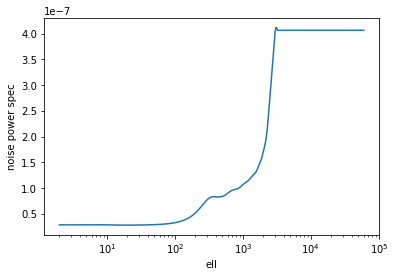

In [6]:
# We plot the noise power spectrum used for cmb tracer noise
cmb_noise_smth = smooth(cmb_noise,10,'flat')
cmb_noise_smth = cmb_noise_smth[0:len(cmb_noise)]
plt.plot(ell,cmb_noise_smth, label='smooth')
plt.xscale('log')
plt.xlabel('ell')
plt.ylabel('noise power spec')

### From here on, we basically follow the example on TJPCov GitHub
The example is here: https://github.com/LSSTDESC/TJPCov/blob/master/examples/Gaussian_cov-DES.ipynb \
But we have to modify the code a little bit to include CMB lensing tracers.

In [7]:
# We set up the basics for analytical covariance
twopoint_data.metadata['fsky']=445./(4*np.pi*((180.**2)/(np.pi**2)))
twopoint_data.metadata['ell']=np.concatenate((np.linspace(2, 500-1, 500-2), np.logspace(np.log10(500), np.log10(6e4), 500)))
twopoint_data.metadata['ell_bins']=np.arange(2,500,20)
th_min=1/60 # in degrees
th_max=300./60
n_th_bins=20
twopoint_data.metadata['th_bins']=np.logspace(np.log10(2.5/60.),np.log10(250./60.),n_th_bins+1)
th=np.logspace(np.log10(th_min),np.log10(th_max),3000) #covariance is oversampled at th values and then binned.
th2=np.linspace(1,th_max*1.02,3000) #binned covariance can be sensitive to the th values. Make sue you check convergence for your application
twopoint_data.metadata['th']=np.unique(np.sort(np.append(th,th2)))
thb=0.5*(twopoint_data.metadata['th_bins'][1:]+twopoint_data.metadata['th_bins'][:-1])

In [8]:
WT_factors={}
WT_factors['ck','wl']=(0,2)
WT_factors['wl','ck']=(2,0)
WT_factors['gc','ck']=(0,0)
WT_factors['ck','gc']=(0,0)

In [9]:
# Wigner Transform setup... 
WT_kwargs={'l': twopoint_data.metadata['ell'],'theta': twopoint_data.metadata['th']*d2r,'s1_s2':[(0,2),(2,0),(0,0)]}
%time WT=wigner_transform(**WT_kwargs)

CPU times: user 577 ms, sys: 2.59 s, total: 3.17 s
Wall time: 39 s


In [10]:
def get_tracer_info(two_point_data={}):
    ccl_tracers={}
    tracer_Noise={}
    for tracer in twopoint_data.tracers:
        
        if tracer != 'ck':
            tracer_dat=twopoint_data.get_tracer(tracer)
            z= tracer_dat.z
            
            Ngal = 0.053 #arc_min^2
            sigma_e=.0097
            b = 1.0*np.ones(len(z)) #Galaxy bias (constant with scale and z)
            AI = .5*np.ones(len(z)) #Galaxy bias (constant with scale and z)
            Ngal=Ngal*3600/d2r**2
            
            dNdz = tracer_dat.nz
            dNdz/=(dNdz*np.gradient(z)).sum()
            dNdz*=Ngal
            
        
            if 'wl' in tracer or 'wl' in tracer:  
                ccl_tracers[tracer]=ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz),ia_bias=(z,AI)) #CCL automatically normalizes dNdz
                tracer_Noise[tracer]=sigma_e**2/Ngal
            elif 'gc' in tracer:
                tracer_Noise[tracer]=1./Ngal
                ccl_tracers[tracer]=ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
                
################### this is the part where we have to do a little modification to include CMB lensing tracer noise #########################       
        else: 
            ccl_tracers[tracer]=ccl.CMBLensingTracer(cosmo,1100.)
            tracer_Noise[tracer]=cmb_noise_smth 
    return ccl_tracers,tracer_Noise

In [11]:
ccl_tracers, tracer_Noise = get_tracer_info(twopoint_data)

In [12]:
def get_cov_WT_spin(tracer_comb=None):
#     tracers=tuple(i.split('_')[0] for i in tracer_comb)
    tracers=[]
    for i in tracer_comb:
        if 'ck' in i:
            tracers+=['ck']
        if 'wl' in i:
            tracers+=['wl']
        if 'gc' in i:
            tracers += ['gc'] 
    return WT_factors[tuple(tracers)]

In [13]:
#compute a single covariance matrix for a given pair of C_ell or xi.  
def cl_gaussian_cov(tracer_comb1=None,tracer_comb2=None,ccl_tracers=None,tracer_Noise=None,two_point_data=None,do_xi=False,
                    xi_plus_minus1='plus',xi_plus_minus2='plus'):  
    #fsky should be read from the sacc
    #tracers 1,2,3,4=tracer_comb1[0],tracer_comb1[1],tracer_comb2[0],tracer_comb2[1]
    ell=two_point_data.metadata['ell']
    cl={}
    cl[13] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[0]], ccl_tracers[tracer_comb2[0]], ell)
    cl[24] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[1]], ccl_tracers[tracer_comb2[1]], ell)
    cl[14] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[0]], ccl_tracers[tracer_comb2[1]], ell)
    cl[23] = ccl.angular_cl(cosmo, ccl_tracers[tracer_comb1[1]], ccl_tracers[tracer_comb2[0]], ell)
    
    SN={}
    SN[13]=tracer_Noise[tracer_comb1[0]] if tracer_comb1[0]==tracer_comb2[0]  else 0
    SN[24]=tracer_Noise[tracer_comb1[1]] if tracer_comb1[1]==tracer_comb2[1]  else 0
    SN[14]=tracer_Noise[tracer_comb1[0]] if tracer_comb1[0]==tracer_comb2[1]  else 0
    SN[23]=tracer_Noise[tracer_comb1[1]] if tracer_comb1[1]==tracer_comb2[0]  else 0
    
    if do_xi:
        norm=np.pi*4*two_point_data.metadata['fsky']
    else: #do c_ell
        norm=(2*ell+1)*np.gradient(ell)*two_point_data.metadata['fsky']

    coupling_mat={}
    coupling_mat[1324]=np.eye(len(ell)) #placeholder
    coupling_mat[1423]=np.eye(len(ell)) #placeholder
    
    cov={}
    cov[1324]=np.outer(cl[13]+SN[13],cl[24]+SN[24])*coupling_mat[1324]
    cov[1423]=np.outer(cl[14]+SN[14],cl[23]+SN[23])*coupling_mat[1423]
    
    cov['final']=cov[1423]+cov[1324]
    
    if do_xi:
        s1_s2_1=get_cov_WT_spin(tracer_comb=tracer_comb1)
        s1_s2_2=get_cov_WT_spin(tracer_comb=tracer_comb2)
        if isinstance(s1_s2_1,dict):
            s1_s2_1=s1_s2_1[xi_plus_minus1] 
        if isinstance(s1_s2_2,dict):
            s1_s2_2=s1_s2_2[xi_plus_minus2] 
        th,cov['final']=WT.projected_covariance2(l_cl=ell,s1_s2=s1_s2_1, s1_s2_cross=s1_s2_2,
                                                      cl_cov=cov['final'])

    cov['final']/=norm
    
    if do_xi:
        thb,cov['final_b']=bin_cov(r=th/d2r,r_bins=two_point_data.metadata['th_bins'],cov=cov['final']) 
    else:
        if two_point_data.metadata['ell_bins'] is not None:
            lb,cov['final_b']=bin_cov(r=ell,r_bins=two_point_data.metadata['ell_bins'],cov=cov['final']) 
            
#     cov[1324]=None #if want to save memory
#     cov[1423]=None #if want to save memory
    return cov

In [14]:
tracer_comb1 = ['gc0', 'ck']
tracer_comb2 = ['wl0', 'ck']

In [15]:
cov = cl_gaussian_cov(tracer_comb1=tracer_comb1,tracer_comb2=tracer_comb2,
                ccl_tracers=ccl_tracers,tracer_Noise=tracer_Noise,
                two_point_data=twopoint_data,do_xi=True,
                    xi_plus_minus1='plus',xi_plus_minus2='plus')

In [16]:
def get_all_cov(two_point_data={},do_xi=True):
    #FIXME: Only input needed should be two_point_data, which is the sacc data file. Other parameters should be included within sacc and read from there.
    ccl_tracers,tracer_Noise=get_tracer_info(two_point_data=two_point_data)
    tracer_combs=two_point_data.get_tracer_combinations()# we will loop over all these
    N2pt=len(tracer_combs)
    if two_point_data.metadata['ell_bins'] is not None:
        Nell_bins=len(two_point_data.metadata['ell_bins'])-1
    else:
        Nell_bins=len(two_point_data.metadata['ell'])
    if do_xi:
        Nell_bins=len(two_point_data.metadata['th_bins'])-1
    cov_full=np.zeros((Nell_bins*N2pt,Nell_bins*N2pt))
    for i in np.arange(N2pt):
        print("{}/{}".format(i+1, N2pt))
        tracer_comb1=tracer_combs[i]
        indx_i=i*Nell_bins
        for j in np.arange(i,N2pt):
            tracer_comb2=tracer_combs[j]
            indx_j=j*Nell_bins
            cov_ij=cl_gaussian_cov(tracer_comb1=tracer_comb1,tracer_comb2=tracer_comb2,ccl_tracers=ccl_tracers,
                                        tracer_Noise=tracer_Noise,do_xi=do_xi,two_point_data=two_point_data)
            if do_xi or two_point_data.metadata['ell_bins'] is not None:
                cov_ij=cov_ij['final_b']
            else:
                cov_ij=cov_ij['final']
            cov_full[indx_i:indx_i+Nell_bins,indx_j:indx_j+Nell_bins]=cov_ij
            cov_full[indx_j:indx_j+Nell_bins,indx_i:indx_i+Nell_bins]=cov_ij.T
    return cov_full

In [ ]:
cov = get_all_cov(two_point_data=twopoint_data, do_xi=True)

1/2
2/2


### Here we show some results
This is the covariance matrix, looking weird probably because we set the l>3000 noise the same as l=3000, whereas in reality it should be much smaller than that.

In [ ]:
plt.imshow(cov[:])
plt.colorbar()

##### Loading the covariance matrices calculated by jackknife

In [ ]:
NKcov = np.loadtxt('/global/u1/z/zhzhuoqi/MCMC/map1/80-100/NK/cov.txt')
GKcov = np.loadtxt('/global/u1/z/zhzhuoqi/MCMC/map1/80-100/GK/cov.txt')
theta_deg = np.loadtxt('/global/u1/z/zhzhuoqi/MCMC/map1/80-100/GK/theta_deg.txt')

In [ ]:
# NK covariance from TJPCov
plt.imshow(cov[0:20,0:20])
plt.colorbar()

In [ ]:
# NK covariance from jackknife
plt.imshow(NKcov)
plt.colorbar()

In [ ]:
# GK covariance from TJPCov
plt.imshow(cov[20:,20:])
plt.colorbar()

In [ ]:
# GK covariance from jackknife
plt.imshow(GKcov)
plt.colorbar()

In [ ]:
# correlation matrxi from TJPCov
err=np.sqrt(np.diag(cov))
corr_m=cov/np.outer(err,err)
plt.imshow(corr_m)
plt.colorbar()